# `MEDUSA`

### Setup and definitions

First, we set up a database with temporally distributed exchanges.

In [1]:
from tests.databases import *
db_abc_loopA_with_biosphere_tds_CO2_and_CH4()

100%|██████████| 2/2 [00:00<00:00, 10356.31it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 29330.80it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 32896.50it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 4/4 [00:00<00:00, 62601.55it/s]

Vacuuming database 


The point of `Medusa` is to choose processes from different background databases depending on the timing of a process. To do so, we need to know which database represents what time:

In [64]:
from datetime import datetime

database_date_dict = {
    "background_2008": datetime.strptime("2008", "%Y"),
    "background_2024": datetime.strptime("2024", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

Also, we can define at what point the underlying graph traversal should stop traversing the supply chain graph, i.e. where we don't expect any more significant temporal distributions or scores. We do this with a filter-function. For now, we just tell it to diregard all nodes in the background databases:

In [65]:
SKIPPABLE = [
    node.id for node in bd.Database('background_2008')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Lastly, we of course need to define our demand (functional unit) and impact assessment method:

In [66]:
demand = {('foreground', 'A'): 1}
method = ('GWP', 'example')

### MedusaLCA calculation

Now we can create our `MedusaLCA`. On creation, it automatically calculates a static LCA of the system, starts the graph traversal and stores the temporal information internally.

In [67]:
from medusa import MedusaLCA
mlca = MedusaLCA(demand, method, filter_function, database_date_dict, max_calc=5000)

Starting graph traversal
Calculation count: 34


Now, we can build the timeline of exchanges between processes. Note how in addition to the orignal database ids, we now have "time mapped" ids for all consumers and producers, repesenting the time-specific version of the processes.

In [68]:
import warnings
warnings.filterwarnings("ignore")
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,1997,11,1997-01-01,3,C,2002,16,2002-01-01,9,B,13.0,{'background_2008': 1}
1,1998,12,1998-01-01,3,C,2003,17,2003-01-01,9,B,13.0,{'background_2008': 1}
2,1999,13,1999-01-01,3,C,2004,18,2004-01-01,9,B,13.0,{'background_2008': 1}
3,2000,14,2000-01-01,9,B,2020,43,2020-01-01,10,A,3.6,{'background_2008': 1}
4,2001,15,2001-01-01,9,B,2021,47,2021-01-01,10,A,3.6,{'background_2008': 1}
...,...,...,...,...,...,...,...,...,...,...,...,...
69,2035,63,2035-01-01,9,B,2020,43,2020-01-01,10,A,0.4,{'background_2024': 1}
70,2036,64,2036-01-01,9,B,2021,47,2021-01-01,10,A,0.4,{'background_2024': 1}
71,2037,65,2037-01-01,9,B,2022,51,2022-01-01,10,A,0.4,{'background_2024': 1}
72,2038,66,2038-01-01,9,B,2023,55,2023-01-01,10,A,0.4,{'background_2024': 1}


Next, we tell the MedusaLCA to build the datapackage including the matrix modifications, adding the time-specific version of processes, including the new technosphere and biosphere exchanges.

In [69]:
mlca.build_datapackage()

The `MedusaLCA.datapackage` now stores a list of two `bw_processing.Datapackage` objects, essentially containing sparse matrix representations of the changes to the technosphere and biosphere. 

In [ ]:
# mlca.datapackage[0].data # technosphere changes

In [ ]:
# mlca.datapackage[0].data # biosphere changes

Just like a normal LCA, we can now calculate the inventory and do the impact assessment:

In [75]:
mlca.lci()
mlca.lcia()

Let's compare the results of the static LCA and the MedusaLCA:

In [76]:
print('Old static LCA Score:', mlca.static_lca.score)
print('New MEDUSA LCA Score:', mlca.score)

Old static LCA Score: 2657.222226621744
New MEDUSA LCA Score: 2653.3894588780236


The overall score in this example should be the same (or at least very close), because we didn't change any exchange values.

### Dynamic biosphere exchanges

In addition to the overall score, representing temporal changes in technosphere exchanges, we can also look at temporal changes in the biosphere exchanges. To do that, 

In [55]:
mlca.build_dynamic_biosphere()

In [12]:
mlca.calculate_dynamic_lci()

In [13]:
mlca.dynamic_inventory

{'CO2': {'time': array(['1997-01-01T00:00:00', '1998-01-01T00:00:00',
         '1999-01-01T00:00:00', '2008-01-01T00:00:00',
         '2011-01-01T00:00:00', '2012-01-01T00:00:00',
         '2013-01-01T00:00:00', '2014-01-01T00:00:00',
         '2015-01-01T00:00:00', '2016-01-01T00:00:00',
         '2017-01-01T00:00:00', '2018-01-01T00:00:00',
         '2019-01-01T00:00:00', '2020-01-01T00:00:00',
         '2020-12-31T17:27:36', '2021-01-01T00:00:00',
         '2021-12-31T17:27:36', '2022-01-01T00:00:00',
         '2022-12-31T17:27:36', '2023-01-01T00:00:00',
         '2024-01-01T00:00:00', '2024-01-01T17:27:36',
         '2024-12-31T17:27:36', '2025-12-31T17:27:36',
         '2026-12-31T17:27:36', '2027-01-01T00:00:00',
         '2028-01-01T00:00:00', '2032-01-01T00:00:00',
         '2033-01-01T00:00:00', '2034-01-01T00:00:00'],
        dtype='datetime64[s]'),
  'amount': array([3.31812005e+00, 1.40400002e+00, 4.68000000e+01, 0.00000000e+00,
         2.34808140e+00, 2.15851552e+00, 3.2

In [14]:
mlca.dynamic_inventory['CO2']['amount'].sum()

238.45593712643526

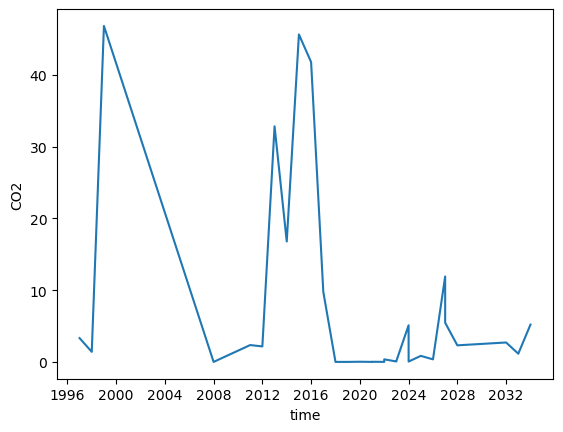

In [15]:
mlca.plot_dynamic_inventory('CO2')

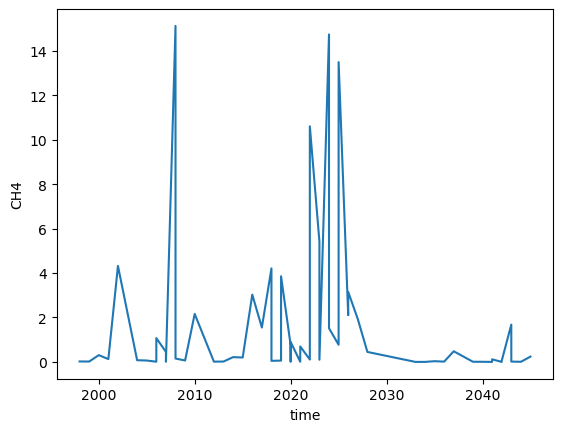

In [16]:
mlca.plot_dynamic_inventory('CH4')

In [17]:
mlca.create_labelled_technosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"((background_2024, C), 2024)",1.0,0.0,0.0,0.0,-11.0,0.0,-13.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
"((background_2024, electricity_wind), 2024)",-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, C), 2008)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((background_2008, electricity_wind), 2008)",0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"((foreground, E), dynamic)",0.0,0.0,0.0,0.0,1.0,-2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"((foreground, B), 2035)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"((foreground, B), 2036)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"((foreground, B), 2037)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"((foreground, B), 2038)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
mlca.create_labelled_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0


In [19]:
mlca.create_labelled_dynamic_biosphere_dataframe()

,"((background_2024, C), 2024)","((background_2024, electricity_wind), 2024)","((background_2008, C), 2008)","((background_2008, electricity_wind), 2008)","((foreground, E), dynamic)","((foreground, D), dynamic)","((foreground, B), dynamic)","((foreground, A), dynamic)","((background_2024, C), 1997)","((background_2024, C), 1998)",...,"((background_2024, C), 2027)","((background_2024, C), 2028)","((background_2024, C), 2032)","((background_2024, C), 2033)","((background_2024, C), 2034)","((foreground, B), 2035)","((foreground, B), 2036)","((foreground, B), 2037)","((foreground, B), 2038)","((foreground, B), 2039)"
"(CO2, 2024-01-01T00:00:00)",1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 2008-01-01T00:00:00)",0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1997-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1998-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(CO2, 1999-01-01T00:00:00)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(CH4, 2041-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0
"(CH4, 2044-01-01T10:55:12)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
"(CH4, 2036-12-31T12:21:36)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
"(CH4, 2042-12-31T23:16:48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
